In [108]:
import pandas as pd
import numpy as np

#for visualisations of graphs
import matplotlib.pyplot as plt
%matplotlib inline

#for datetime object
from datetime import datetime

#statsmodel libraires
from statsmodels.tsa.stattools import adfuller                 #To check stationarity in Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX         #SARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing   #Holt's Winter Method

#ARIMA
from pmdarima import auto_arima

#Skit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [109]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [110]:
#Import the monthly rainfall data(from January 1901 to December 1970) for two locations:
# 1. AJMER
tamilnadu  = pd.read_csv("Tamilnadu_rainfall_data.csv")
# 2. JAIPUR
karnataka = pd.read_csv("Karnataka_rainfall_data.csv")

In [111]:
tamilnadu.head()

,YEAR,MONTH,Datetime,Rainfall
0,1901,Jan,01-01-1901,5.082
1,1901,Feb,02-01-1901,0.769
2,1901,Mar,03-01-1901,0.182
3,1901,Apr,04-01-1901,0.291
4,1901,May,05-01-1901,3.470


In [112]:
karnataka.tail()

,YEAR,MONTH,Datetime,Rainfall
1459,2023,Aug,08-01-2023,31.136
1460,2023,Sep,09-01-2023,0.000
1461,2023,Oct,10-01-2023,2.205
1462,2023,Nov,11-01-2023,206.000
1463,2023,Dec,12-01-2023,31.136


In [113]:
tamilnadu  = tamilnadu.drop(['YEAR', 'MONTH'], axis=1)
karnataka = karnataka.drop(['YEAR', 'MONTH'], axis=1)

In [114]:
tamilnadu.dtypes
karnataka.dtypes

Datetime     object
Rainfall    float64
dtype: object

In [115]:
tamilnadu['Datetime'] = pd.to_datetime(tamilnadu.Datetime,format='%m-%d-%Y')
karnataka['Datetime'] = pd.to_datetime(karnataka.Datetime,format='%m-%d-%Y')

In [116]:
#create months column
for i in (tamilnadu, karnataka):
    i['month']=i.Datetime.dt.month

In [117]:
tamilnadu.dtypes
karnataka.dtypes

Datetime    datetime64[ns]
Rainfall           float64
month                int32
dtype: object

In [118]:
tamilnadu.head()


,Datetime,Rainfall,month
0,1901-01-01,5.082,1
1,1901-02-01,0.769,2
2,1901-03-01,0.182,3
3,1901-04-01,0.291,4
4,1901-05-01,3.470,5


In [119]:
karnataka.tail()

,Datetime,Rainfall,month
1459,2023-08-01,31.136,8
1460,2023-09-01,0.000,9
1461,2023-10-01,2.205,10
1462,2023-11-01,206.000,11
1463,2023-12-01,31.136,12


# Plot cummulative monthly rainfall

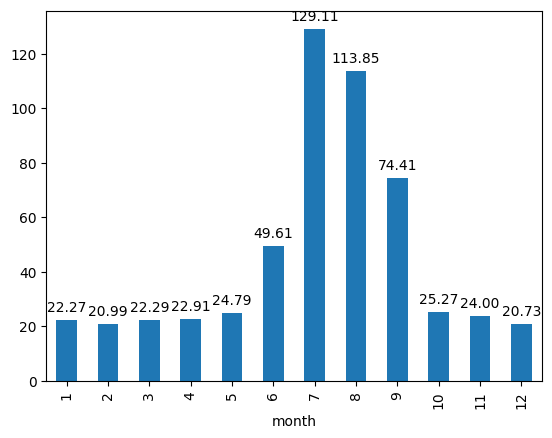

In [120]:
import matplotlib.pyplot as plt

# Assuming 'tamilnadu' is your DataFrame
ax = tamilnadu.groupby('month')['Rainfall'].mean().plot.bar()

# Adding values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()


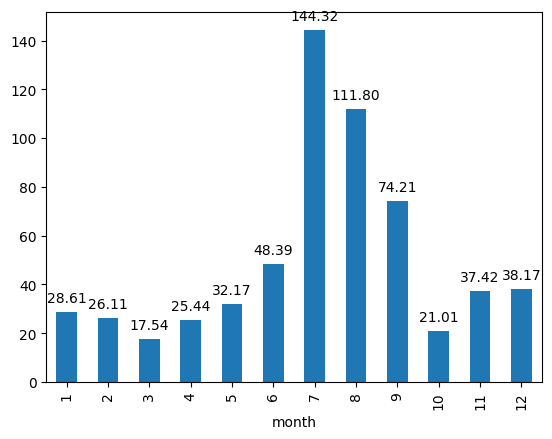

In [121]:
ax = karnataka.groupby('month')['Rainfall'].mean().plot.bar()

# Adding value annotations on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

In [122]:
#Create timestamp
tamilnadu.Timestamp = pd.to_datetime(tamilnadu.Datetime,format='%m-%d-%Y')
tamilnadu.index = tamilnadu.Timestamp


In [123]:
karnataka.Timestamp = pd.to_datetime(karnataka.Datetime,format='%m-%d-%Y')
karnataka.index = karnataka.Timestamp

In [124]:
tamilnadu  = tamilnadu.drop(['Datetime','month'], axis=1)
karnataka = karnataka.drop(['Datetime','month'], axis=1)

In [125]:
tamilnadu.head()

,Rainfall
Datetime,
1901-01-01,5.082
1901-02-01,0.769
1901-03-01,0.182
1901-04-01,0.291
1901-05-01,3.470


In [126]:
karnataka.tail()

,Rainfall
Datetime,
2023-08-01,31.136
2023-09-01,0.000
2023-10-01,2.205
2023-11-01,206.000
2023-12-01,31.136


<Axes: xlabel='Datetime'>

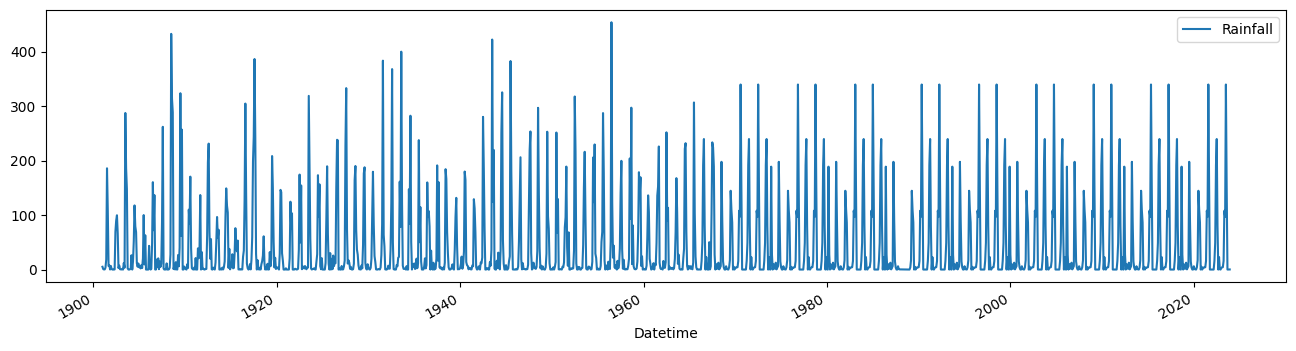

In [127]:
tamilnadu.plot(figsize=(16,4))

<Axes: xlabel='Datetime'>

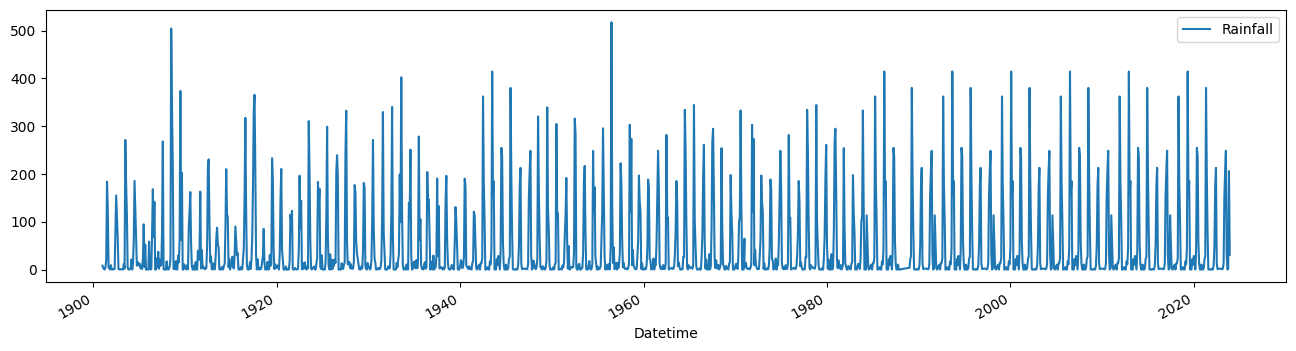

In [128]:
karnataka.plot(figsize=(16,4))

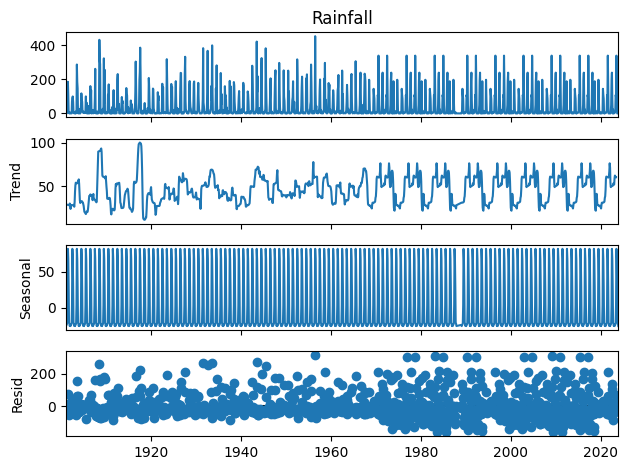

In [129]:
result = seasonal_decompose(tamilnadu['Rainfall'], model='additive', period=12)
result.plot()
plt.show()

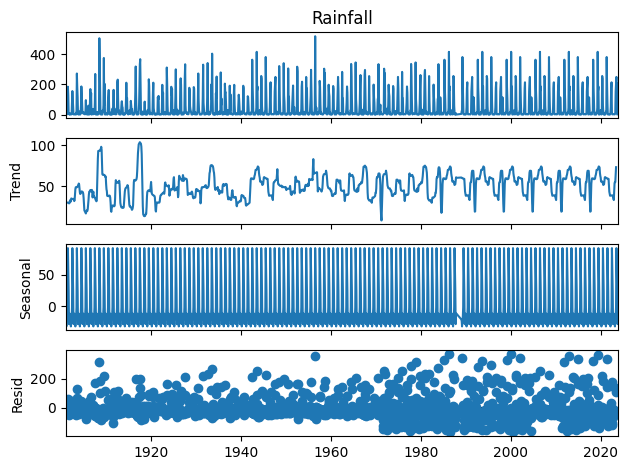

In [130]:
result = seasonal_decompose(karnataka['Rainfall'], model='additive', period=12)
result.plot()
plt.show()

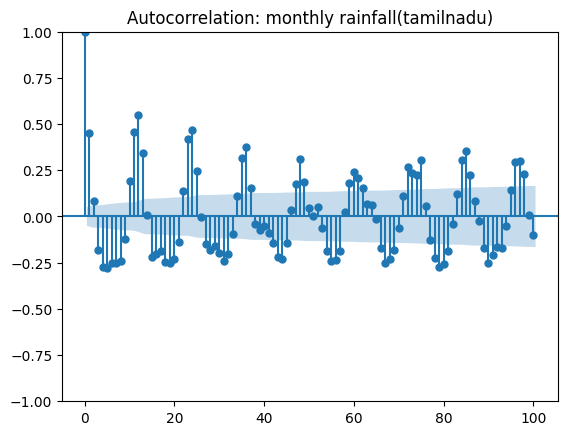

In [131]:
title = 'Autocorrelation: monthly rainfall(tamilnadu)'
lags = 100
plot_acf(tamilnadu,title=title,lags=lags);

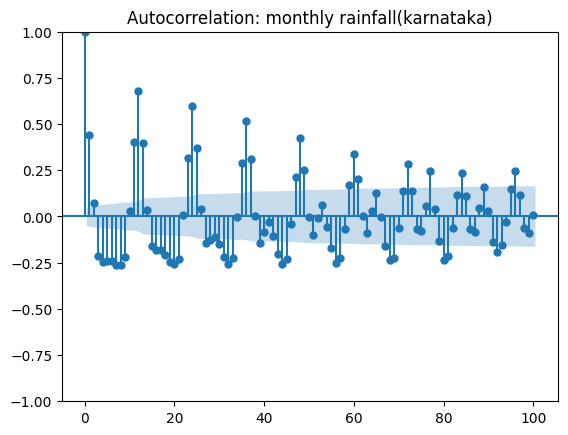

In [132]:
title = 'Autocorrelation: monthly rainfall(karnataka)'
lags = 100
plot_acf(karnataka,title=title,lags=lags);

# Let's check Stationary of the Time Series using Augmented Dickey-Fuller Test

# Null hypothesis is that datasets are not stationary

In [133]:
print('Augmented Dickey-Fuller Test on tamilnadu Rainfall Data')
dftest = adfuller(tamilnadu['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on tamilnadu Rainfall Data


(-8.446288158406473,
 1.70930524565312e-13,
 23,
 1440,
 {'1%': -3.434899302257815,
  '5%': -2.8635492080466607,
  '10%': -2.567839687982253},
 15716.38297221095)

In [134]:
print('Augmented Dickey-Fuller Test on karnataka Rainfall Data')
dftest = adfuller(karnataka['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on karnataka Rainfall Data


(-7.805732657377552,
 7.290424950170775e-12,
 23,
 1440,
 {'1%': -3.434899302257815,
  '5%': -2.8635492080466607,
  '10%': -2.567839687982253},
 15765.580326766889)

In [135]:
len(tamilnadu)
len(karnataka)

1464

In [136]:
train_a = tamilnadu.iloc[:1300]
test_a = tamilnadu.iloc[1300:]

train_j = karnataka.iloc[:1300]
test_j = karnataka.iloc[1300:]

In [137]:
modelstep_fit = auto_arima(tamilnadu['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

modelstep_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=16332.680, Time=5.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16965.615, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16357.775, Time=2.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16470.893, Time=2.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17385.362, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=16640.212, Time=1.18 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=16431.735, Time=1.92 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=10.63 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=16332.634, Time=13.63 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=16500.103, Time=3.24 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=12.72 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=16.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=16233.146, Time=18.45 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=16386.690, Time=8.87 sec
 ARIMA(0,0,1)(1,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1464
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 12)   Log Likelihood               -8107.658
Date:                              Fri, 05 Jul 2024   AIC                          16227.316
Time:                                      19:48:31   BIC                          16259.050
Sample:                                           0   HQIC                         16239.152
                                             - 1464                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0339      0.530      1.952      0.051      -0.004       2.072
ar.L1          0.2579      0.023     11.225      0.000       0.213       0.303
ar.S.L12       1.1537      0.033     35.011      0.000       1.089       1.218
ar.S.L24      -0.1862      0.027     -6.903      0.000      -0.239      -0.133
ma.S.L12      -0.8446      0.025    -34.389      0.000      -0.893      -0.796
sigma2      3753.3106    100.630     37.298      0.000    3556.079    3950.542
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              2848.45
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                             1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
modelstep_fit = auto_arima(karnataka['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

modelstep_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=16249.381, Time=4.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=17271.530, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16295.125, Time=3.81 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16617.382, Time=2.36 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17684.555, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=16752.254, Time=1.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=16352.202, Time=1.56 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=12.28 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=16248.137, Time=13.97 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=16549.447, Time=3.42 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=12.79 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=16174.125, Time=15.19 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=16424.489, Time=8.54 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=16174.308, Time=3.86 sec
 ARIMA(1,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1464
Model:             SARIMAX(6, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -8043.492
Date:                              Fri, 05 Jul 2024   AIC                          16106.985
Time:                                      20:03:17   BIC                          16159.874
Sample:                                           0   HQIC                         16126.712
                                             - 1464                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9574      1.746      3.412      0.001       2.536       9.379
ar.L1          0.2050      0.022      9.217      0.000       0.161       0.249
ar.L2          0.1011      0.027      3.750      0.000       0.048       0.154
ar.L3         -0.1157      0.048     -2.414      0.016      -0.210      -0.022
ar.L4         -0.0713      0.042     -1.718      0.086      -0.153       0.010
ar.L5         -0.0814      0.049     -1.664      0.096      -0.177       0.014
ar.L6         -0.0904      0.047     -1.933      0.053      -0.182       0.001
ar.S.L12       0.8866      0.014     64.053      0.000       0.859       0.914
ma.S.L12      -0.4872      0.021    -23.185      0.000      -0.528      -0.446
sigma2      3490.7958     87.282     39.995      0.000    3319.727    3661.864
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              4827.37
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Tamilnadu

In [139]:
model = SARIMAX(train_a['Rainfall'],order=(0,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                   Rainfall   No. Observations:                 1300
Model:             SARIMAX(1, 0, [1], 12)   Log Likelihood               -7230.992
Date:                    Fri, 05 Jul 2024   AIC                          14467.984
Time:                            20:03:18   BIC                          14483.494
Sample:                                 0   HQIC                         14473.804
                                   - 1300                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9473      0.008    120.896      0.000       0.932       0.963
ma.S.L12      -0.6148      0.019    -31.675      0.000      -0.653      -0.577
sigma2      3934.1679     87.932     44.741      0.000    3761.824    4106.512
===================================================================================
Ljung-Box (L1) (Q):                  69.37   Jarque-Bera (JB):              1616.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                             1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
start=len(train_a)
end=len(train_a)+len(test_a)-1
predicted_a = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,0)(1,0,1,12) Predictions')

In [142]:
# Verify contents and lengths of test_a and predicted_a
print("Length of predicted_a:", len(predicted_a))
print("Length of test_a:", len(test_a))

# Check if lengths match
if len(predicted_a) != len(test_a):
    raise ValueError("Mismatch in the lengths of test data and predictions.")

# Compare predictions to expected values using iloc for safe indexing
for i in range(len(predicted_a)):
    print(f"predicted={predicted_a.iloc[i]}, expected={test_a['Rainfall'].iloc[i]}")


Length of predicted_a: 164
Length of test_a: 164
predicted=1.975368843995503, expected=0.478
predicted=2.778038456310914, expected=0.0
predicted=5.971365732259709, expected=3.23
predicted=14.826542356709663, expected=3.967
predicted=21.009926486885117, expected=4.309
predicted=27.104925643678623, expected=15.802
predicted=31.114294220072875, expected=107.894
predicted=92.24451591531324, expected=96.931
predicted=133.39159074674296, expected=339.508
predicted=116.65351188101104, expected=152.583
predicted=52.253899656906974, expected=0.019
predicted=9.438747058170495, expected=0.039
predicted=1.8711884785555557, expected=0.0
predicted=2.6315255341979453, expected=0.183
predicted=5.656437679175658, expected=0.0
predicted=14.044594921612632, expected=0.0
predicted=19.901869211443394, expected=15.914
predicted=25.675419925106365, expected=49.175
predicted=29.47333559500072, expected=191.453
predicted=87.37956757561459, expected=239.483
predicted=126.35655791586005, expected=79.71
predicted

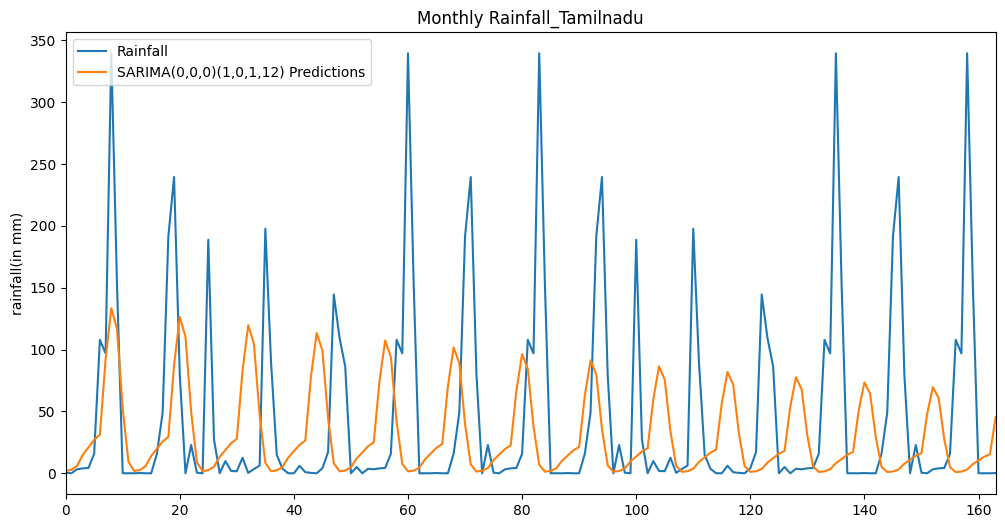

In [146]:
test_a_reset = test_a.reset_index(drop=True)
predicted_a_reset = predicted_a.reset_index(drop=True)

# Plot predictions against known values
title = 'Monthly Rainfall_Tamilnadu'
ylabel = 'rainfall(in mm)'
xlabel = ''

ax = test_a_reset['Rainfall'].plot(legend=True, figsize=(12,6), title=title)
predicted_a_reset.plot(ax=ax, legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.show()

In [154]:
error = rmse(test_a['Rainfall'], predicted_a)
print(f'RMSE Error for ARIMA on tamilnadu rainfall: {error}')

RMSE Error for ARIMA on tamilnadu rainfall: 91.38215484710615


# Karnataka

In [148]:
model = SARIMAX(train_j['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                 1300
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -7149.621
Date:                              Fri, 05 Jul 2024   AIC                          14307.243
Time:                                      20:08:18   BIC                          14327.923
Sample:                                           0   HQIC                         14315.002
                                             - 1300                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2361      0.021     11.184      0.000       0.195       0.277
ar.S.L12       0.9292      0.007    124.881      0.000       0.915       0.944
ma.S.L12      -0.5198      0.016    -32.076      0.000      -0.552      -0.488
sigma2      3471.6438     57.448     60.431      0.000    3359.048    3584.240
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):              5749.95
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
# Obtain predicted values

start=len(train_j)
end=len(train_j)+len(test_j)-1
predicted_j = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')



In [151]:
# Verify contents and lengths of test_a and predicted_a
print("Length of predicted_a:", len(predicted_j))
print("Length of test_a:", len(test_j))

# Check if lengths match
if len(predicted_j) != len(test_j):
    raise ValueError("Mismatch in the lengths of test data and predictions.")

# Compare predictions to expected values using iloc for safe indexing
for i in range(len(predicted_j)):
    print(f"predicted={predicted_j.iloc[i]}, expected={test_j['Rainfall'].iloc[i]}")

Length of predicted_a: 164
Length of test_a: 164
predicted=8.272904006411215, expected=1.733
predicted=33.399037422129865, expected=11.996
predicted=214.95986561522625, expected=153.368
predicted=171.93720844807794, expected=206.671
predicted=43.32310384653457, expected=248.532
predicted=2.048658808887202, expected=31.136
predicted=0.698801652459884, expected=0.0
predicted=0.9891787067554956, expected=2.205
predicted=3.8526119330448836, expected=113.515
predicted=5.39994503019065, expected=55.006
predicted=5.577144552678382, expected=3.324
predicted=4.683893775369926, expected=0.0
predicted=8.694886409907149, expected=1.956
predicted=31.27270447210289, expected=8.168
predicted=199.79958118952413, expected=10.111
predicted=159.77947956920968, expected=0.014
predicted=40.25950444594617, expected=13.308
predicted=1.904378823303964, expected=13.565
predicted=0.6495098359289593, expected=23.811
predicted=0.9191985139255245, expected=362.346
predicted=3.579905222195369, expected=179.874
pred

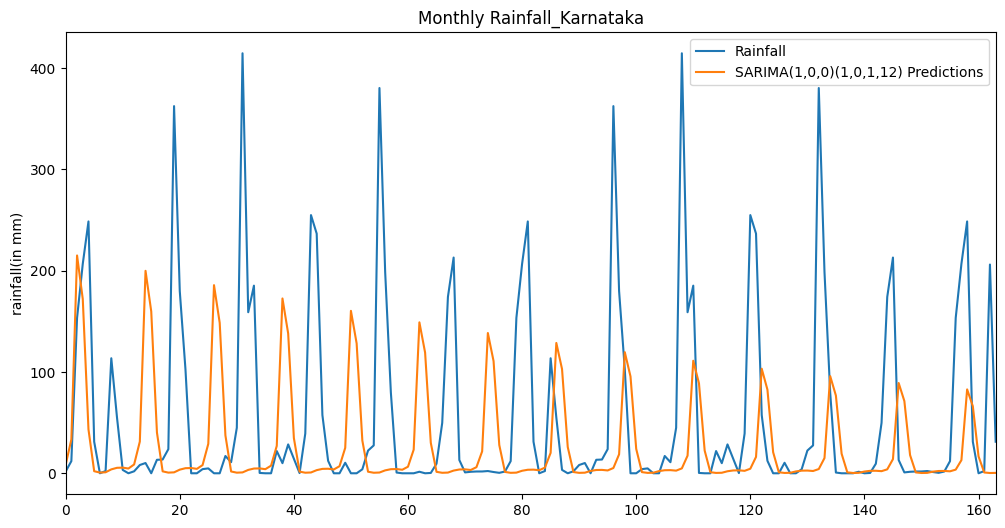

In [152]:
test_j_reset = test_j.reset_index(drop=True)
predicted_j_reset = predicted_j.reset_index(drop=True)

# Plot predictions against known values
title = 'Monthly Rainfall_Karnataka'
ylabel = 'rainfall(in mm)'
xlabel = ''

ax = test_j_reset['Rainfall'].plot(legend=True, figsize=(12,6), title=title)
predicted_j_reset.plot(ax=ax, legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.show()

In [155]:
error = rmse(test_j['Rainfall'], predicted_j)
print(f'RMSE Error for ARIMA on Karnataka rainfall: {error}')

RMSE Error for ARIMA on Karnataka rainfall: 114.84172725755174


# Deep Learning (LSTM)

tamilnadu

In [156]:
scaler = MinMaxScaler()
scaler.fit(train_a)
scaled_train = scaler.transform(train_a)
scaled_test = scaler.transform(test_a)

In [157]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [158]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [159]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
model.fit_generator(generator,epochs=50)

Epoch 1/50
1276/1276 [==============================] - 26s 19ms/step - loss: 0.0235
Epoch 2/50
1276/1276 [==============================] - 23s 18ms/step - loss: 0.0169
Epoch 3/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0165
Epoch 4/50
1276/1276 [==============================] - 22s 18ms/step - loss: 0.0167
Epoch 5/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0153
Epoch 6/50
1276/1276 [==============================] - 25s 20ms/step - loss: 0.0145
Epoch 7/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0150
Epoch 8/50
1276/1276 [==============================] - 26s 20ms/step - loss: 0.0146
Epoch 9/50
1276/1276 [==============================] - 25s 20ms/step - loss: 0.0145
Epoch 10/50
1276/1276 [==============================] - 23s 18ms/step - loss: 0.0142
Epoch 11/50
1276/1276 [==============================] - 25s 19ms/step - loss: 0.0133
Epoch 12/50
1276/1276 [==============================] - 23s 18

In [161]:
model.history.history.keys()

dict_keys(['loss'])

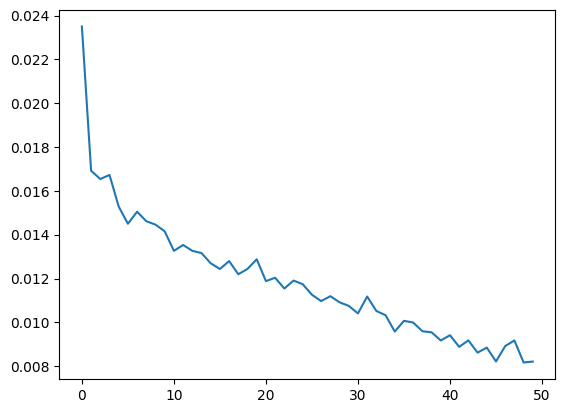

In [162]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [163]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_a)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 39ms/step


In [164]:
test_predictions

[array([-0.01510674], dtype=float32),
 array([-0.00494209], dtype=float32),
 array([0.01261903], dtype=float32),
 array([0.01988823], dtype=float32),
 array([0.0140387], dtype=float32),
 array([0.02622894], dtype=float32),
 array([0.12468387], dtype=float32),
 array([0.15728311], dtype=float32),
 array([0.646584], dtype=float32),
 array([0.2255682], dtype=float32),
 array([-0.02762946], dtype=float32),
 array([-0.00085965], dtype=float32),
 array([-0.01072452], dtype=float32),
 array([-0.0049725], dtype=float32),
 array([0.0043659], dtype=float32),
 array([0.00479089], dtype=float32),
 array([0.00063566], dtype=float32),
 array([0.00289586], dtype=float32),
 array([0.10967629], dtype=float32),
 array([0.6839428], dtype=float32),
 array([0.2186352], dtype=float32),
 array([0.1808832], dtype=float32),
 array([-0.02978992], dtype=float32),
 array([-0.00782365], dtype=float32),
 array([-0.01682939], dtype=float32),
 array([-0.00626218], dtype=float32),
 array([0.01471391], dtype=float32),


In [165]:

true_predictions = scaler.inverse_transform(test_predictions)

In [166]:
test = test_a
test['Predictions'] = true_predictions

In [167]:
test

,Rainfall,Predictions
Datetime,,
2010-05-01,0.478,-6.854153
2010-06-01,0.000,-2.242300
2010-07-01,3.230,5.725445
2010-08-01,3.967,9.023590
2010-09-01,4.309,6.369567
...,...,...
2023-08-01,152.583,2.936477
2023-09-01,0.019,4.023924
2023-10-01,0.039,6.916428


<Axes: xlabel='Datetime'>

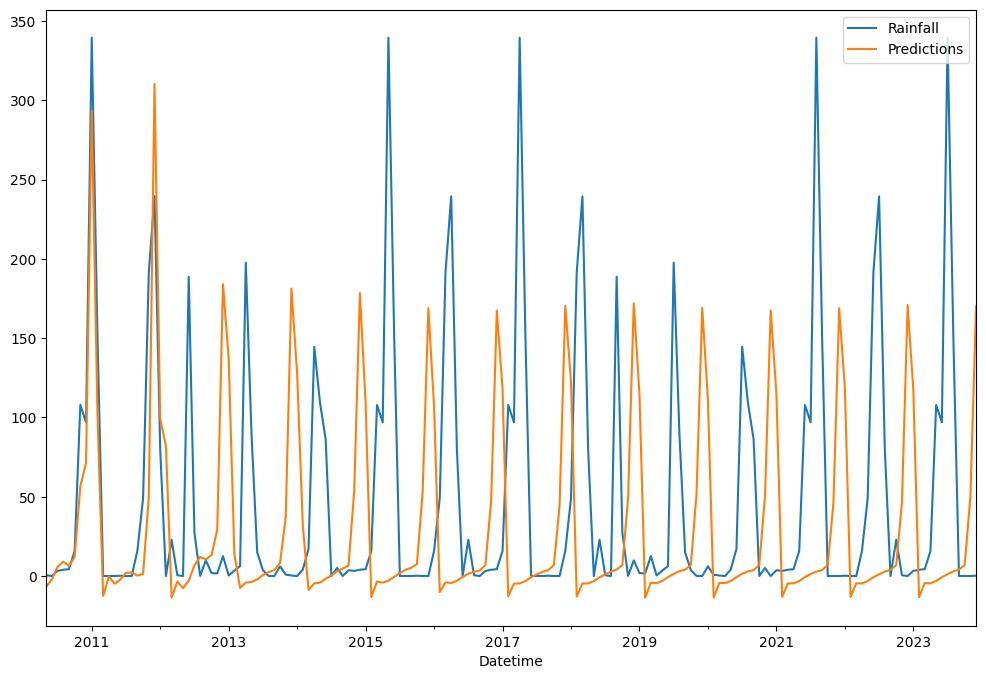

In [168]:
test.plot(figsize=(12,8))

In [169]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

103.79106480311926


# Karnataka

In [170]:
scaler = MinMaxScaler()
scaler.fit(train_j)
scaled_train = scaler.transform(train_j)
scaled_test = scaler.transform(test_j)

In [171]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [172]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [173]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [174]:
model.fit_generator(generator,epochs=50)

Epoch 1/50
1276/1276 [==============================] - 25s 19ms/step - loss: 0.0202
Epoch 2/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0156
Epoch 3/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0148
Epoch 4/50
1276/1276 [==============================] - 25s 20ms/step - loss: 0.0142
Epoch 5/50
1276/1276 [==============================] - 25s 20ms/step - loss: 0.0126
Epoch 6/50
1276/1276 [==============================] - 23s 18ms/step - loss: 0.0135
Epoch 7/50
1276/1276 [==============================] - 25s 19ms/step - loss: 0.0128
Epoch 8/50
1276/1276 [==============================] - 23s 18ms/step - loss: 0.0125
Epoch 9/50
1276/1276 [==============================] - 23s 18ms/step - loss: 0.0123
Epoch 10/50
1276/1276 [==============================] - 22s 17ms/step - loss: 0.0125
Epoch 11/50
1276/1276 [==============================] - 24s 19ms/step - loss: 0.0119
Epoch 12/50
1276/1276 [==============================] - 24s 19

In [175]:
model.history.history.keys()

dict_keys(['loss'])

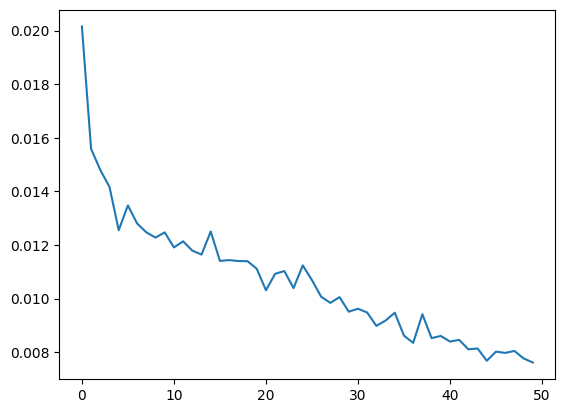

In [176]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [177]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_j)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 32ms/step


In [178]:
test_predictions

[array([0.03592626], dtype=float32),
 array([0.08793733], dtype=float32),
 array([0.44094834], dtype=float32),
 array([0.35179055], dtype=float32),
 array([0.1607841], dtype=float32),
 array([0.00752739], dtype=float32),
 array([0.02408578], dtype=float32),
 array([0.03955686], dtype=float32),
 array([0.04641278], dtype=float32),
 array([0.05317686], dtype=float32),
 array([0.04650237], dtype=float32),
 array([0.04881288], dtype=float32),
 array([0.05885953], dtype=float32),
 array([0.14510407], dtype=float32),
 array([0.22909084], dtype=float32),
 array([0.17863446], dtype=float32),
 array([0.0546519], dtype=float32),
 array([0.00813551], dtype=float32),
 array([0.01929887], dtype=float32),
 array([0.03655349], dtype=float32),
 array([0.07294385], dtype=float32),
 array([0.14953256], dtype=float32),
 array([0.17614219], dtype=float32),
 array([0.15733533], dtype=float32),
 array([0.15207455], dtype=float32),
 array([0.10252656], dtype=float32),
 array([0.10632975], dtype=float32),
 ar

In [179]:
true_predictions = scaler.inverse_transform(test_predictions)

In [180]:
test = test_j
test['Predictions'] = true_predictions

In [181]:
test

,Rainfall,Predictions
Datetime,,
2010-05-01,1.733,18.595899
2010-06-01,11.996,45.517503
2010-07-01,153.368,228.240592
2010-08-01,206.671,182.091361
2010-09-01,248.532,83.223938
...,...,...
2023-08-01,31.136,142.904485
2023-09-01,0.000,164.614889
2023-10-01,2.205,129.409359


<Axes: xlabel='Datetime'>

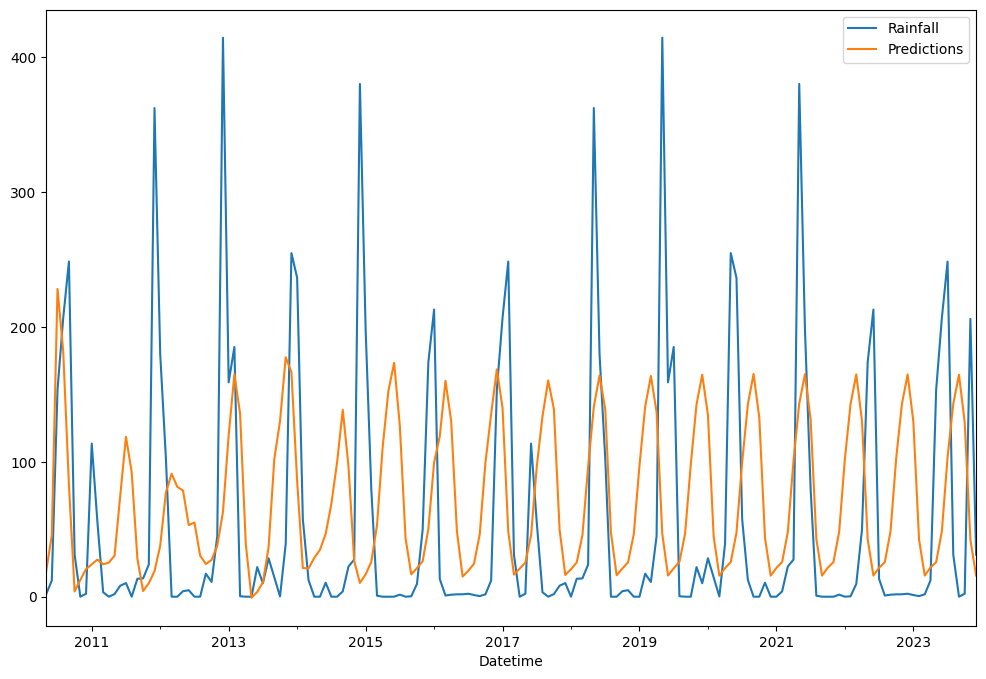

In [182]:
test.plot(figsize=(12,8))

In [183]:
test_a = test_a.drop(['Predictions'], axis=1)
test_j = test_j.drop(['Predictions'], axis=1)

In [184]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

108.21821940113571


In [186]:
scaler = MinMaxScaler()
scaler.fit(tamilnadu)
scaled_data = scaler.transform(tamilnadu)

In [187]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [188]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [189]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [190]:
model.fit_generator(generator,epochs=50)

Epoch 1/50
1440/1440 [==============================] - 26s 17ms/step - loss: 0.0234
Epoch 2/50
1440/1440 [==============================] - 25s 17ms/step - loss: 0.0175
Epoch 3/50
1440/1440 [==============================] - 26s 18ms/step - loss: 0.0168
Epoch 4/50
1440/1440 [==============================] - 25s 17ms/step - loss: 0.0156
Epoch 5/50
1440/1440 [==============================] - 25s 17ms/step - loss: 0.0147
Epoch 6/50
1440/1440 [==============================] - 25s 18ms/step - loss: 0.0138
Epoch 7/50
1440/1440 [==============================] - 24s 17ms/step - loss: 0.0133
Epoch 8/50
1440/1440 [==============================] - 26s 18ms/step - loss: 0.0126
Epoch 9/50
1440/1440 [==============================] - 24s 17ms/step - loss: 0.0130
Epoch 10/50
1440/1440 [==============================] - 25s 17ms/step - loss: 0.0121
Epoch 11/50
1440/1440 [==============================] - 24s 17ms/step - loss: 0.0121
Epoch 12/50
1440/1440 [==============================] - 24s 17

In [191]:
model.history.history.keys()

dict_keys(['loss'])

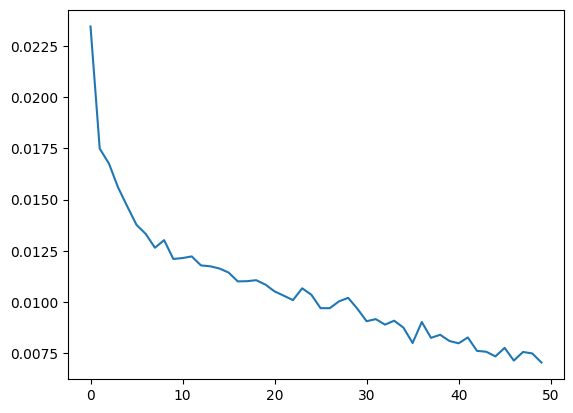

In [192]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [193]:
Forecasted_rainfall = []

first_eval_batch = scaled_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(1,361):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    Forecasted_rainfall.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 32ms/step


In [194]:
tamilnadu_rainfall = scaler.inverse_transform(Forecasted_rainfall)

In [195]:
tamilnadu_rainfall

array([[ 4.17100682e+00],
       [ 2.88468172e+00],
       [ 6.70219591e+00],
       [ 3.30598767e+01],
       [ 1.64469895e+02],
       [ 2.30809316e+02],
       [ 8.96973704e+01],
       [ 2.15158932e+01],
       [ 1.80257916e+00],
       [ 3.00824019e+00],
       [ 1.14387909e+01],
       [ 1.81709629e+01],
       [ 1.81000818e+01],
       [ 1.46485696e+01],
       [ 2.02198088e+01],
       [ 5.34408920e+01],
       [ 9.10526294e+01],
       [ 1.82133817e+02],
       [ 8.72402095e+01],
       [ 1.30974884e+01],
       [ 4.11737613e+00],
       [ 4.10329322e+00],
       [ 5.96748428e+00],
       [ 6.16695053e+00],
       [ 1.53019343e+00],
       [ 2.07359919e+00],
       [ 2.39432369e+01],
       [ 8.76683085e+01],
       [ 1.77964625e+02],
       [ 1.16154223e+02],
       [ 6.02414113e+01],
       [-1.67047156e+00],
       [ 9.46759880e-02],
       [ 2.65691780e+00],
       [ 4.90788869e+00],
       [ 4.87707936e+00],
       [ 4.04483189e+00],
       [ 6.29258459e+00],
       [ 3.2

In [199]:
model = SARIMAX(karnataka['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                 1464
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -8094.757
Date:                              Fri, 05 Jul 2024   AIC                          16197.514
Time:                                      22:16:44   BIC                          16218.670
Sample:                                           0   HQIC                         16205.405
                                             - 1464                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2493      0.021     11.617      0.000       0.207       0.291
ar.S.L12       0.9080      0.008    107.353      0.000       0.891       0.925
ma.S.L12      -0.4603      0.017    -27.828      0.000      -0.493      -0.428
sigma2      3689.1131     57.729     63.904      0.000    3575.967    3802.260
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):              6299.83
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [201]:
start=len(karnataka)
end=len(karnataka)+360-1
karnataka_rainfall = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [202]:
karnataka_rainfall

1464     10.343617
1465      4.687675
1466      5.770367
1467     21.172479
1468    163.449500
           ...    
1819      0.899042
1820      0.019399
1821      0.086387
1822      5.704972
1823      0.943999
Name: SARIMA(1,0,0)(1,0,1,12) Predictions, Length: 360, dtype: float64

In [203]:
karnataka_rainfall.to_csv('karnataka_rainfall.csv',index=False)